# Linear Decision Tree

In dit notebook wordt een Linear Decision Tree model getraind op de geprepareerde dataset. Dit is een model die eerst een decision tree aanmaakt en bij de leaves gebruikt het model een lineare regressie model om de target waardes te voorspellen.

In [1]:
# Importeer gebruikte libraries
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from baseline import calculate_baseline
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm

Er wordt een test-train split gemaakt voor het trainen en testen van het model.

In [2]:
model_df = pd.read_pickle("data/model_df.pkl")
train_df = pd.read_pickle("data/train_df.pkl")
test_df = pd.read_pickle("data/test_df.pkl")

X_train = train_df.drop('anm_tot_fh', axis=1)
y_train = train_df['anm_tot_fh']

X_test = test_df.drop('anm_tot_fh', axis=1)
y_test = test_df['anm_tot_fh']

Voor dit model worden alleen de continue features gebruikt voor het maken van de lineaire regressie modellen bij de leafes. De features die hiervoor gebruikt worden zijn: oorz_code_enc, geo_code_enc, contractgb_enc, techn_enc (indeces: [1,2,3,4]).

De RMSE en R2 scores worden berekend voor verschillende dieptes en met elkaar vergeleken.

In [3]:
depths = range(1, 11) 

train_rmse, test_rmse = [], []
train_r2, test_r2 = [], []

# Train LTR model met verschillende max_depths
for depth in tqdm(depths):
    regressor = LinearTreeRegressor(base_estimator=LinearRegression(), 
                                    min_samples_leaf=0.05,
                                    linear_features=[1,2,3,4],
                                    max_depth=depth, 
                                    n_jobs=-1)
    regressor.fit(X_train, y_train)

    # Voorspellingen op de train set
    train_predictions = regressor.predict(X_train)
    train_rmse.append(sqrt(mean_squared_error(y_train, train_predictions)))
    train_r2.append(r2_score(y_train, train_predictions))

    # Voorspellingen op de test set
    test_predictions = regressor.predict(X_test)
    test_rmse.append(sqrt(mean_squared_error(y_test, test_predictions)))
    test_r2.append(r2_score(y_test, test_predictions))

100%|██████████| 10/10 [02:11<00:00, 13.12s/it]


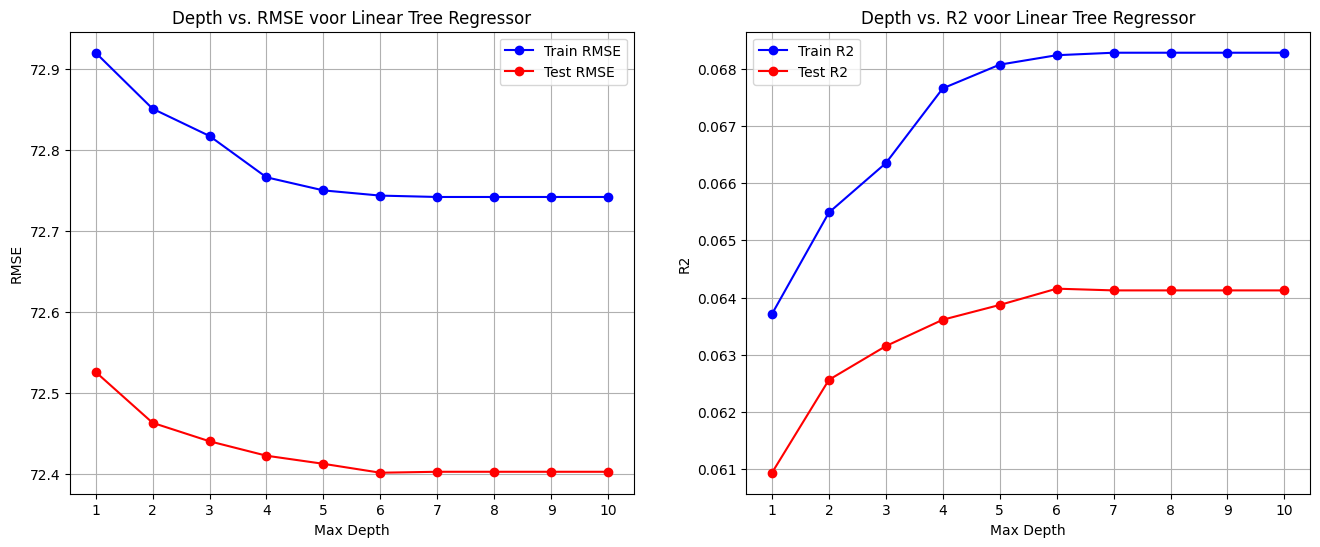

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot RMSE
ax1.plot(depths, train_rmse, marker='o', linestyle='-', color='b', label='Train RMSE')
ax1.plot(depths, test_rmse, marker='o', linestyle='-', color='r', label='Test RMSE')
ax1.set_title('Depth vs. RMSE voor Linear Tree Regressor')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('RMSE')
ax1.set_xticks(depths)
ax1.grid(True)
ax1.legend()

# Plot R2 score
ax2.plot(depths, train_r2, marker='o', linestyle='-', color='b', label='Train R2')
ax2.plot(depths, test_r2, marker='o', linestyle='-', color='r', label='Test R2')
ax2.set_title('Depth vs. R2 voor Linear Tree Regressor')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('R2')
ax2.set_xticks(depths)
ax2.grid(True)
ax2.legend()

plt.show()


Een max_depth van 6 blijkt optimaal voor dit model (te zien in plots hierboven). Nu wordt er een model getraint met deze max_depth

In [5]:
max_depth = 6
regressor = LinearTreeRegressor(base_estimator=LinearRegression(), 
                                min_samples_leaf=0.05,
                                linear_features=[1,2,3,4],
                                max_depth=max_depth, 
                                n_jobs=-1)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

y_pred = regressor.predict(X_test)

print("Root Mean Squared Error: ", rmse)
print("R-squared (R2) Score: ", r2)

baseline_rmse, baseline_r2 = calculate_baseline(model_df)
print('Baseline RMSE: ', baseline_rmse)
print('Baseline R2: ', baseline_r2)

Root Mean Squared Error:  72.4014121881622
R-squared (R2) Score:  0.06415579773695534
Baseline RMSE:  75.25674049973072
Baseline R2:  0.0


Hieronder wordt het gevonden model geplot. Bij elke node staat diens MSE en bij elke split node staat de kolom en diens splitwaarde.

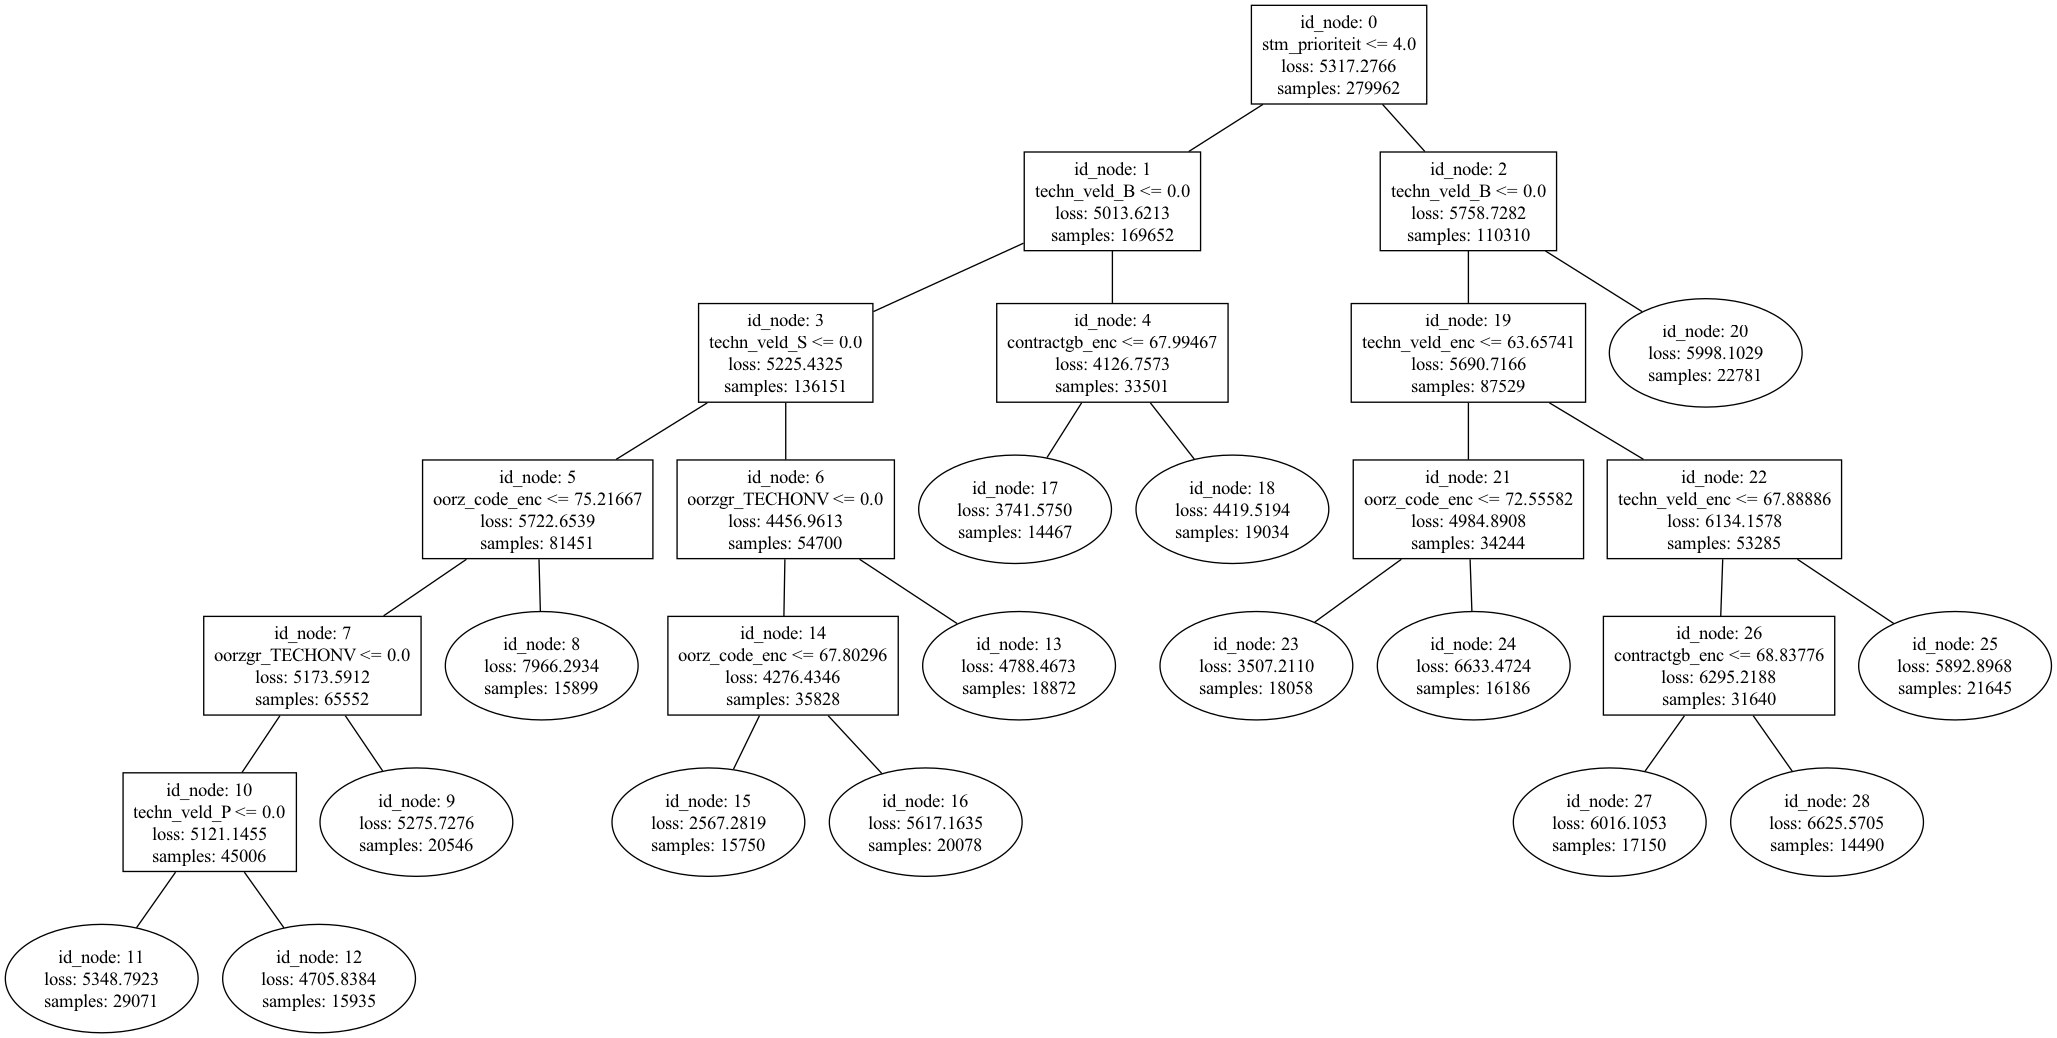

In [6]:
"""
Soms werkt deze code niet omdat een library gebruikt wordt door linear-tree (pydot library), niet toegevoegd is aan je system PATH.
"""

regressor.plot_model(feature_names=list(X_train.columns))

In [7]:
rmse = sorted({key: sqrt(val['loss']) for key, val in regressor.summary(only_leaves=True).items()}.items(), key=lambda x: x[1])
for leaf, score in rmse:
    print("Leaf Node {} has RMSE {}".format(leaf, score))

Leaf Node 15 has RMSE 50.668352252663595
Leaf Node 23 has RMSE 59.22171012390642
Leaf Node 17 has RMSE 61.168414643506985
Leaf Node 18 has RMSE 66.47946622830241
Leaf Node 12 has RMSE 68.59911355112396
Leaf Node 13 has RMSE 69.19875186735669
Leaf Node 9 has RMSE 72.63420427043997
Leaf Node 11 has RMSE 73.13543799007428
Leaf Node 16 has RMSE 74.94773832478202
Leaf Node 25 has RMSE 76.76520546445505
Leaf Node 20 has RMSE 77.44742022817803
Leaf Node 27 has RMSE 77.56355645533539
Leaf Node 28 has RMSE 81.39760758154996
Leaf Node 24 has RMSE 81.44613189096214
Leaf Node 8 has RMSE 89.25409458394611


## Conclusie

Het gevonden model is beter dan het baseline model (zowel RMSE als R2). Er zijn ook specifieke leaves gevondendie een stuk betere voorspelling geven (leaves 15, 23). 